# Set up

In [1]:
%load_ext autoreload
%autoreload 2
import os
import cifar_utils
import clipper_manager as cl
import pandas as pd
import numpy as np
from sklearn import linear_model as lm
from sklearn import svm
import tensorflow as tf
from skimage import io
import matplotlib as mpl
mpl.rc("savefig", dpi=200)
import matplotlib.pyplot as plt
%matplotlib inline


from traitlets.config.manager import BaseJSONConfigManager
cfg_path = "/Users/crankshaw/anaconda2/envs/clipper/etc/jupyter/nbconfig"
cm = BaseJSONConfigManager(config_dir=cfg_path)
cm.update('livereveal', {
              'theme': 'simple',
              'transition': 'none',
              'start_slideshow_at': 'selected',
})

{u'start_slideshow_at': 'selected', u'theme': 'simple', u'transition': 'none'}

# Set up EC2 instance

In [3]:
import clipper_manager as cl
ec2_host = "ec2-54-67-123-237.us-west-1.compute.amazonaws.com"
user = "ubuntu"
key = os.path.expanduser("~/.ssh/aws_rsa")
clipper = cl.Cluster(ec2_host, user, key)
clipper.stop_all()
clipper.pull_docker_images()

Checking if Docker is running...
Found Docker running
Checking if docker-compose is installed...
Found docker-compose installed
Creating internal Docker network
Stopping Clipper and all running models...
[ec2-54-67-123-237.us-west-1.compute.amazonaws.com] sudo: docker pull clipper/query_frontend:test
[ec2-54-67-123-237.us-west-1.compute.amazonaws.com] sudo: docker pull clipper/management_frontend:test
[ec2-54-67-123-237.us-west-1.compute.amazonaws.com] sudo: docker pull redis
[ec2-54-67-123-237.us-west-1.compute.amazonaws.com] sudo: docker pull clipper/sklearn_cifar_container:test
[ec2-54-67-123-237.us-west-1.compute.amazonaws.com] sudo: docker pull clipper/tf_cifar_container:test


### Load CIFAR-10 data and train/load models

In [6]:
cifar_path = os.path.expanduser("~/model-serving/data/cifar")
train_x, train_y = cifar_utils.filter_data(
    *cifar_utils.load_cifar(cifar_path, cifar_filename="cifar_train.data", norm=True))
test_x, test_y = cifar_utils.filter_data(
    *cifar_utils.load_cifar(cifar_path, cifar_filename="cifar_test.data", norm=True))
no_norm_x, no_norm_y = cifar_utils.filter_data(
    *cifar_utils.load_cifar(cifar_path, cifar_filename="cifar_test.data", norm=False))

# Train Scikit-Learn Logistic Regression model
def train_model(m, train_x, train_y):
    m.fit(train_x, train_y)
    return m
lin_model = train_model(lm.LogisticRegression(), train_x, train_y)

# Load pre-trained TF model
tf_cifar_model_path = os.path.expanduser(
    "~/clipper-cpp/examples/cifar_demo/tf_cifar_model/cifar10_model_full")
tf_session = tf.Session('', tf.Graph())
with tf_session.graph.as_default():
    saver = tf.train.import_meta_graph("%s.meta" % tf_cifar_model_path)
    saver.restore(tf_session, tf_cifar_model_path)

def tensorflow_score(session, test_x, test_y):
    """
    NOTE: This predict method expects pre-whitened (normalized) images
    """
    logits = session.run('softmax_logits:0',
                           feed_dict={'x:0': test_x})
    relevant_activations = logits[:, [cifar_utils.negative_class, cifar_utils.positive_class]]
    preds = np.argmax(relevant_activations, axis=1)
    preds[preds == 0] = -1.0
    return float(np.sum(preds == test_y)) / float(len(test_y))


Number of image files: 50000
Number of image files: 10000
Number of image files: 10000


<h1 align="center">DEMO</h1> 

<h2 align="center">Is it a bird? Is it a plane? It's probably not Superman...</h2> 
![Alt](superman.png#center)

![Alt](superman.png#center)

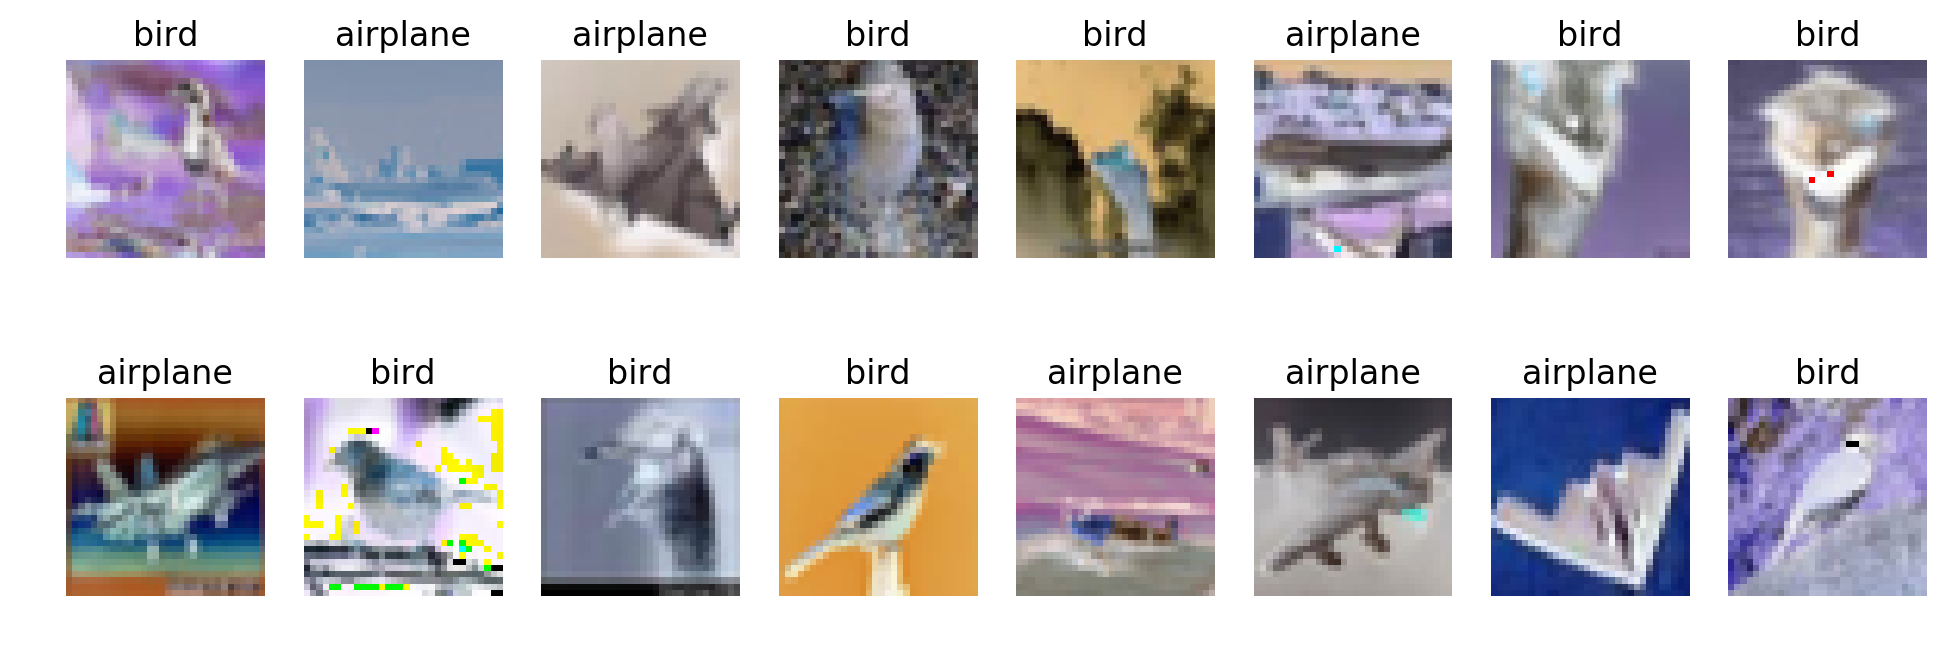

In [8]:
cifar_utils.show_example_images(no_norm_x, no_norm_y, 2)

In [9]:
import clipper_manager as cl
ec2_host = "ec2-54-67-123-237.us-west-1.compute.amazonaws.com"
user = "ubuntu"
key = os.path.expanduser("~/.ssh/aws_rsa")
clipper = cl.Cluster(ec2_host, user, key)

clipper.start_clipper()

Checking if Docker is running...
Found Docker running
Checking if docker-compose is installed...
Found docker-compose installed
Creating internal Docker network
Clipper is running


In [10]:
# "Can now interact with Clipper. For instance..."
clipper.list_apps()
# so let's register one with Clipper. As a data scientist...

Clipper has no applications registered


In [11]:
app_name = "superman_detection"
candidate_models = [
    {"model_name": "sklearn_cifar", "model_version": 1},
    {"model_name": "tf_cifar", "model_version": 1},
]

clipper.register_application(
    name=app_name,
    candidate_models=candidate_models,
    input_type="doubles",
    slo_micros=20000)

Success!


In [ ]:
clipper.list_apps()

# Start a serving workload

# Start with logistic regression...

In [ ]:
type(lin_model)
print("Logistic Regression test score: %f" % lin_model.score(test_x, test_y))

### Deploy to Clipper

In [ ]:
# TODO TODO TODO: Before merge, change :test to :latest

# deploy a model we just trained in same session we registered
# application
# without having to worry about any external dependencies
model_added = clipper.deploy_model(
    name="sklearn_cifar",
    version=1,
    model_data=lin_model,
    container_name="clipper/sklearn_cifar_container:test",
    labels=["cifar", "sklearn"],
    input_type="doubles",
    num_containers=1
)

Check accuracy of serving workload

## Deploy TensorFlow Model to Clipper

In [ ]:
print("TensorFlow CNN test score: %f" % tensorflow_score(tf_session, test_x, test_y))

In [ ]:
# TODO TODO TODO: Before merge, change :test to :latest

model_added = clipper.deploy_model(
    name="tf_cifar",
    version=1,
    model_data="/Users/crankshaw/clipper-cpp/examples/cifar_demo/tf_cifar_model",
    container_name="clipper/tf_cifar_container:test",
    labels=["cifar", "tf"],
    input_type="doubles",
    num_containers=1
)

Check accuracy of serving workload

In [ ]:
clipper.get_bandit_weights(app_name=app_name, uid=0)

## Send some feedback

In [ ]:
# scrolling output:
# change height of scroll window?
# s/send_updates/enable_feedback
cifar_utils.send_updates(ec2_host, app_name, test_x, test_y, 100)

(go back to accuracy plot)

In [ ]:
# "reason why you see the jump in accuracy..."
# "putting more weight on the more accurate model, so we're seeing
# an improvement in the overall appplication accuracy"
clipper.get_bandit_weights(app_name=app_name, uid=0)

+ easy for data scientist to roll out app
+ easy for the data scientist to improve accuracy by using heterogeneous models


+ throughout this whole process, interaction with the application was completely independent from any changes to the models
+ disassociating interaction with the application from any improvements to the application by the data scientist

# Clean Up

In [ ]:
# clipper.stop_all()
# clipper.pull_docker_images()
clipper.cleanup()